The spatial distribution of the bulge MSPs as implied by the distribution of low mass X-ray binaries follows a $r^{-2.4}$ profile, which is also consistent with the γ-ray excess data.

In [1166]:
import numpy as np
import plotly
import plotly.graph_objs as go
import random
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn-whitegrid')
from amuse.units import units
import copy
import powerlaw

In [1222]:
# ehists_scratch = np.load("ehists_scratch_1e10.npz", allow_pickle=True)
ehists_scratch = np.load("ehists_bulge_1e6.npz", allow_pickle=True)
# ehists_scratch = np.load("ehists_disk_1e6.npz", allow_pickle=True)
ehists_scratch = ehists_scratch.f.arr_0

# ehists = np.load("ehists_rec.npz", allow_pickle=True)
# ehists = ehists.f.arr_0

In [1223]:
aic_indices = []
t_aic_all = []
ehists = ehists_scratch

with tqdm(total=len(ehists)) as pbar:
    for i in range( len(ehists) ):
#         onewd = False
        aic = False
        try:
            k_onewd = list(ehists[i][:,5]).index(12)
#             onewd = True
            k_ns = list(ehists[i][:,5]).index(13)
            aic_indices.append(i)
            t_aic_all.append(ehists[i][k_ns,0])
            aic = True
        except ValueError:
            aic = False
        pbar.update()    
            
# del ehists

100%|██████████| 57027/57027 [00:03<00:00, 18426.14it/s]


In [1224]:
al = np.linspace(0, np.pi/2, int(1e3))
alpdf = 0.5*np.sin(al)

In [1225]:
# plt.plot(al,alpdf);

In [1226]:
n_ = 1e4
a_sam = []
for i in range(len(al)):
    a_sam += [al[i]]*int(n_*alpdf[i])

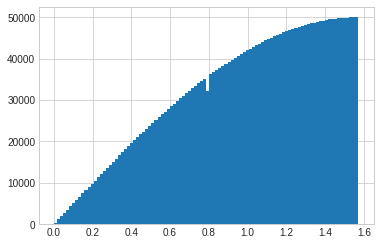

In [1227]:
plt.hist(a_sam,100);

In [1385]:
mu = 8.21
sigma = 0.21
s = np.random.normal(mu, sigma, int(1e6))
B_sim_chris = 10**s
x = np.linspace(min(B_sim_chris), max(B_sim_chris), int(2.3e3))
p = (np.sqrt(2*np.pi)*sigma)**-1 * np.exp( -(np.log10(x)-np.log10(10**mu))**2 /(2*sigma**2)  )
B_sam = []
for i in range(len(x)):
    B_sam += [x[i]]*int(len(x)*p[i])

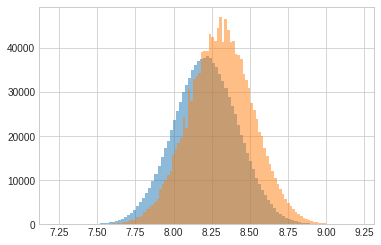

In [1386]:
plt.hist(np.log10(B_sim_chris),100, alpha = 0.5);
# plt.plot(np.log10(x), np.log10(n_*p));
plt.hist(np.log10(B_sam), 100, alpha = 0.5);

In [1387]:
M_bulge = 1.55e10
# M_sim = 7.3e8
M_sim = 2e9
k_bulge = M_bulge/M_sim

In [1388]:
M_disk = 3.7e10
# M_sim = 1.63e8
M_sim = 2e9
k_disk = M_disk/M_sim

In [1389]:
def magnetic_braking(P, dt, B, mass, m_dot, radius, a, AIC, P_wd = 0, m_old = 1.44, r_old = 0.0145):
    P_old = P
    ddt = dt
    if AIC==True:
        w_s = 0
        G = 1.3218607e+26               # km**3 * MSun**(-1) * yr**(-2)
        RSun = 695700   ## km
        radius = radius * RSun * 1e5     ## cm
        c = 2.998e10 ## cm/s
        alp = np.random.random()
        
        t_g = 47 * (mass/1.4)**-1 * (radius/10)**-4 * (P/1e-3)**6 / 3.154e+7    #syr

        T = 1e9
        tb = 2.7e11 * (mass/1.4) * (radius/10)**-1 * (P/1e-3)**2 * (T/1e9)**-6 / 3.154e+7     #yr
        ts = 6.7e7 * (mass/1.4)**(-5/4) * (radius/10)**(23/4) * (P/1e-3)**2 * (T/1e9)**2 / 3.154e+7     #yr
        tau = 1 / abs(tb**-1 + ts**-1 - abs(t_g)**-1)
        Jc = 3 * 1.635e-2 * alp**2 * mass*radius**2 / 2
        Jc_dot = - 2* Jc/tau
                      
        dt = tau   #yr
                      
        I = (0.4)*(mass*radius**2)      ##g cm^2
        Idot = (I - (0.4)*(m_old * (r_old*RSun*1e5)**2)) / dt    
        w_wd = ( 2 * np.pi / P_wd ) * 3.154e+7   ##yr^-1
        w = ( 2 * np.pi / P ) * 3.154e+7   ##yr^-1
        wdot = (w - w_wd) / dt
#         m_coll_dot = abs(mass - m_old) / dt

#         wdot = 3 * 1.635e-2 * alp**2 * w / (0.261*t_g)
        Jdot = Idot*w + I*wdot + Jc_dot
        wdot = (Jdot/I) * (1 - (3 * 1.635e-2 * alp**2 / (2*0.261)))**-1 - (m_dot*w/mass)
        w = w - wdot*dt
        P = ( 2 * np.pi / w ) * 3.154e+7
           
    mdot_lim = 0   
    if m_dot > mdot_lim: ## MB Accretion-Torque Model-2019, Gittins and Andersson et. al. ::: Accretng Millisecond X-ray Pulsars (AMXPs
        g = 6.67408e-11 |(units.m**3 * units.kg**(-1) * units.s**(-2))
        gauss = units.cm**(-1.0/2) * units.g**(1.0/2) * units.s**(-1)
        b = B |gauss
        mass = mass |units.MSun
        r = radius |units.RSun
        m_dot = m_dot |units.MSun/units.yr
        dt = dt |units.yr
        w = ( 2 * np.pi / P ) * 3.154e+7   ##yr^-1
        w_old = w |units.yr**-1

        mu = b*r**3         ## G cm^3

        I = (0.4)*(mass*r**2)
#         I = I.as_quantity_in(units.g * units.cm**2) 
        # print(I)
    
        r_A = ( (mu)**4 / (2*g*mass * m_dot**2) )**(1.0/7.0)   
        r_A = r_A.as_quantity_in(units.km)       # km
        r_m = xi*r_A
        r_c = (g*mass/w_old**2)**(1.0/3.0) 

        w = ( 2 * np.pi / P ) * 3.154e+7
        w_K_r_m = np.sqrt(g*mass/r_m**3)        
        w_K_r_m = w_K_r_m.as_quantity_in(1/units.yr)  
        w_s = w / w_K_r_m.value_in(units.yr**(-1)) 
        P_old = P
        if r_m.value_in(units.km) < r_c.value_in(units.km):
            w_dot = m_dot*np.sqrt(g*mass*r_m)/I
            w = w + w_dot.value_in(units.yr**-2)*dt.value_in(units.yr)
            P = ( 2 * np.pi / w ) * 3.154e+7
            P_dot = (P - P_old)/dt.value_in(units.s)

        if r_m.value_in(units.km) >= r_c.value_in(units.km):
#         else:
            P_dot = - (1-w_s) * 8.1e-5 * np.sqrt(xi) * (mass.value_in(units.MSun)/1.4)**(3.0/7.0) * (1e45/I.value_in(units.g*units.cm**2)) * (mu.value_in(gauss*units.cm**3)/1e30)**(2.0/7.0) * ( P*abs(m_dot.value_in(units.MSun/units.yr)/1e-9)**(3.0/7.0) )**2     ## s/yr
            P_dot = P_dot/3.154e+7   ## s/s
            P = P + P_dot*dt.value_in(units.s)

        Q22 = (1-w_s) * 4.2e37 * xi**0.25 * (mass.value_in(units.MSun)/1.4)**(3.0/14) * (mu.value_in(gauss*units.cm**3)/1e30)**(1.0/7.0) * (m_dot.value_in(units.MSun/units.yr)/1e-9)**(3.0/7.0) * (P**-1 / 500)**(-5.0/2)    ## g cm^2
        Pdot_GW = 1.4e-19 * (1e45/I.value_in(units.g*units.cm**2)) * (Q22/1e37)**2 * P**-3  ##s/yr
        Pdot_GW = Pdot_GW/3.154e+7   ## s/s
        P = P + Pdot_GW*dt.value_in(units.s)
        P_dot = P_dot + Pdot_GW
        w = ( 2 * np.pi / P ) * 3.154e+7


    elif m_dot <= mdot_lim:
        m = mass * 1e33
        radius = radius * 695700 * 1e5     ## cm
        c = 2.998e10 ## cm/s
        I = (0.4)*(m*radius**2)      ##g cm^2
        mu = B*radius**3         ## G cm^3
        w_s = 0

        Q22 = (1-w_s) * 4.2e37 * xi**0.25 * (m/1.4)**(3.0/14) * (mu/1e30)**(1.0/7.0) * (m_dot/1e-9)**(3.0/7.0) * (P**-1 / 500)**(-5.0/2)    ## g cm^2
        Pdot_GW = 1.4e-19 * (1e45/I) * (Q22/1e37)**2 * P**-3  ##s/yr
        Pdot_GW = Pdot_GW/3.154e+7   ## s/s
        P = P + Pdot_GW*dt*3.154e+7
#         print(Pdot_GW)

        P_dot = B**2 *np.pi**2 * radius**6 * (1+ np.sin(a)**2) / (P*I*c**3)
#         P_dot = (B / 3.1782086e+19)**2 * (1+ np.sin(a)**2) / P
        P = P + P_dot * dt * 3.154e+7 
        w = ( 2 * np.pi / P ) * 3.154e+7
        P_dot = P_dot + Pdot_GW
    
    P_dot = (P - P_old)/(ddt*3.154e+7)
    return P, w, w_s, P_dot
        

In [1390]:
# from tqdm import tqdm
# import multiprocessing as mp
# from functools import partial

def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx
    
class Distributions:
    def process(self, i):
        G = 1.3218607e+26               # km**3 * MSun**(-1) * yr**(-2)
        g = 6.67408e-11 |(units.m**3 * units.kg**(-1) * units.s**(-2))
        G = g.value_in(units.RSun**3 * units.MSun**(-1) * units.yr**(-2))
        # c = 9.4605284e12                # km/yr
        RSun = 695700   ## km
        c = 2.998e10 ## cm/s
        cc = 2.998e10 |units.cm / units.s  ## cm/s
        
#         i = aic_indices[j]
        
        t = np.arange(0, t_end, dt)
        time_i = ehists[i][:,0]
        self.birthtimes.append(time_i[0])
        types_i = ehists[i][:,5]
        for k in range(len(types_i)):
            if types_i[k] == 13 and types_i[k-1] == 12:
                aic_ind = k
                self.t_aic.append(time_i[aic_ind])
                break

        begining = True 
        j = 0
#         B = ehists[i][-1,14]
        B = random.choice(B_sam)
#         B = random.choice(B_sim_chris)
        a = random.choice(a_sam)
        for t_i in t:
            j_old = j
            j = find_nearest(time_i, t_i/1e6)
            if j==j_old:
                mdot = 0
                mloss = 0
            else:
                mdot = ehists[i][j,6]
                mloss = ehists[i][j,10]
#             if types_i[j] == 13 and i in aic_indices:
            if types_i[j] == 13:
                w_breakup = np.sqrt(G*ehists[i][j,3]/(ehists[i][j,4]*RSun)**3)
                P_breakup = ( 2 * np.pi /(w_breakup) ) * 3.154e+7    #second
                if accretion == False:
                    mass = ehists[i][j,3] * 1.98e33
                    radius = ehists[i][j,4] * 695700 * 1e5
                    c = 2.998e10 ## cm/s
                    I = (0.4)*(mass*radius**2)      ##g cm^2
                    if begining == True:
                        P_old = ehists[i][j,12]
                        P = ehists[i][j,12]
                        self.Pbirth.append(P)
                        P, w, w_s, P_dot = magnetic_braking(P, dt, B, ehists[i][j,3], 0, ehists[i][j,4], a, True, ehists[i][j-1,12], ehists[i][j-1,3], ehists[i][j-1,4])
                        P, w, w_s, P_dot = magnetic_braking(P, dt, B, ehists[i][j,3], 0, ehists[i][j,4], a, False)
#                         P_dot = (B / 3.1782086e+19)**2 * (1+ np.sin(a)**2) / P
                        P_dot_old = P_dot
                        begining = False
                    else:
                        P = P_old 
                        P, w, w_s, P_dot = magnetic_braking(P, dt, B, ehists[i][j,3], 0, ehists[i][j,4], a, False)
#                         P_dot = (B / 3.1782086e+19)**2 * (1+ np.sin(a)**2) / P
                        P_old = P 
                        P_dot_old = P_dot
                    if P<40e-3 and P_dot > 0 and P_dot_old > 0:
                        self.n[int(t_i/dt)].append( 2 - (P*(P_dot-P_dot_old)/(dt * 3.154e+7))/P_dot**2 )
                    P_dot_old = P_dot

                if accretion == True:
                    if begining == True:
                        l = 1
                        w_wd = ( 2 * np.pi / (ehists[i][j-l,12]) ) * 3.154e+7  
                        w_ns = ( (ehists[i][j-l,3] / ehists[i][j,3]) * ( ehists[i][j-l,4]/ehists[i][j,4] )**2 ) * w_wd
                        P = ( 2 * np.pi / ( w_ns) ) * 3.154e+7  #seconds
#                         P = ehists[i][j,12]
                        self.Pbirth.append(P)
                        P, w, w_s, P_dot = magnetic_braking(P, 500e-3/3.154e+7, B, ehists[i][j,3], mdot, ehists[i][j,4], a, True, ehists[i][j-1,12], ehists[i][j-1,3], ehists[i][j-1,4])
                        P, w, w_s, P_dot = magnetic_braking(P, dt, B, ehists[i][j,3], mdot, ehists[i][j,4], a, False)
                        begining = False
                        P_old = P 
                    else: 
                        P = P_old
                        P, w, w_s, P_dot = magnetic_braking(P, dt, B, ehists[i][j,3], mdot, ehists[i][j,4], a, False)
                        P_old = P 
                        

#                 if P<40e-3 and P_dot > 0:
                if P_dot > 0:
                    f, alpha, beta = 0.0122, -2.12, 0.82                                    ##slot-gap two-pole caustic (TPC) Gonthier 2018
    #                     L_gamma = 2.7621525e22 * f * (P/1e-3)**alpha * (P_dot/1e-21)**beta            ## erg/s
                    L_gamma = 6.8172e35 * f * (P/1e-3)**alpha * (P_dot/1e-20)**beta 
                    self.dNdL_gamma[int(t_i/dt)].append( L_gamma )
                    self.Power[int(t_i/dt)].append( 1/P**2 )
                    self.P_dist[int(t_i/dt)].append( P )
                    self.P_dot_dist[int(t_i/dt)].append( P_dot )
                    self.B_dist[int(t_i/dt)].append( B ) 
                    if L_gamma>1e33:
                        self.detectable[int(t_i/dt)].append( True )
                    else:
                        self.detectable[int(t_i/dt)].append( False )
                    mass =  ehists[i][j,3] * 1.989e+33  ##g
                    r =  ehists[i][j,4] * 6.957e+10     ##cm
                    I = (0.4)*(mass*r**2)      ##g cm^2
                    E_dot = 4 * np.pi**2 * I * P_dot/P**3     # g cm^2 / s^3 = ergs/s
                    self.Edot[int(t_i/dt)].append(E_dot)
                    

            if ehists[i][j,5] in [10,11,12,13] or ehists[i][j,9] in [10,11,12,13]:  ## if primary is an accreting WD or NS
                if mdot>0:   ##primary accreting
                    eta = 1.0  ##η_bol ≈ 0.55
                    R_sch = 2 * G * (ehists[i][j,3]) / c**2
                    xi = 0.5 * R_sch / (ehists[i][j,4])
                    L = eta * xi * abs(mdot) * c**2 
                    L = L * 2e33 * (6.957e+10)**2 / (3.154e+7)**3 
#                     eta = 0.55 * 0.01  ##η_bol ≈ 0.55
#                     L = eta * G * ehists[i][j,3] * abs(ehists[i][j,6]) / (ehists[i][j,4])
#                     L = L * 1.989e33 * (6.957e+10)**2 / (3.154e+7)**3 

                elif mloss>0: ##secondary accreting
                    eta = 1.0   ##η_bol ≈ 0.55
                    R_sch = 2 * G * (ehists[i][j,7]) / c**2
                    xi = 0.5 * R_sch / (ehists[i][j,8])
                    L = eta * xi * abs(mloss) * c**2 
                    L = L * 2e33 * (6.957e+10)**2 / (3.154e+7)**3 
#                     eta = 0.55 * 0.01  ##η_bol ≈ 0.55
#                     L = eta * G * ehists[i][j,7] * abs(ehists[i][j,10]) / (ehists[i][j,8])
#                     L = L * 1.989e33 * (6.957e+10)**2 / (3.154e+7)**3 
                else:
                    L = 0
                if L > 0:
                    self.dNdL_x[int(t_i/dt)].append( L ) 
                    if ehists[i][j,5] in [10,11,12] or ehists[i][j,9] in [10,11,12]:
                        self.dNdL_xwd[int(t_i/dt)].append( L ) 
                    if ehists[i][j,5] == 13 or ehists[i][j,5] == 13:
                        self.dNdL_xns[int(t_i/dt)].append( L )
                    if L >= 1e36:
                        self.Lx_count[int(t_i/dt)] += 1
                    
                    
    def __init__(self, indices):
        t = np.arange(0, t_end, dt)
        self.dNdL_gamma = [[] for _ in range(len(t))]
        self.Edot = [[] for _ in range(len(t))]
        self.L_g_noaic = [[] for _ in range(len(t))]
        self.P_dist = [[] for _ in range(len(t))]
        self.P_dot_dist = [[] for _ in range(len(t))]
        self.Power = [[] for _ in range(len(t))]
        self.B_dist = [[] for _ in range(len(t))]
        self.age = [[] for _ in range(len(t))]
        self.dNdL_x = [[] for _ in range(len(t))]
        self.dNdL_xwd = [[] for _ in range(len(t))]
        self.dNdL_xns = [[] for _ in range(len(t))]
        self.birthtimes = []
        self.detectable = [[] for _ in range(len(t))]
        self.Lx_count = [0 for _ in range(len(t))]
        self.t_aic = []
        self.n = [[] for _ in range(len(t))]
        self.Pbirth = []

#         with tqdm(total=len(ehists)) as pbar:
#             for j in range(len(ehists)):
        with tqdm(total=len(indices)) as pbar:
            for j in indices:
                self.process(j)
                pbar.update()
        print("Done!")
#             ncores = 2
#             args = [(ehists, aic_indices[i]) for i in range(len(aic_indices))]
#             print(args)
#             with mp.Pool(processes=ncores) as pool:

#                 for i in enumerate(pool.starmap(self.process, 
#                                             args )):    
#                     pbar.update()

                    

def call_distributions(indices):
    return Distributions(indices)

In [1391]:
k_bulge, k_disk, len(aic_indices)

(7.75, 18.5, 5124)

In [1394]:
dt = 1e8
t_end = 16e9
accretion = True
# accretion = False
xi = 0.5
ehists = copy.copy(ehists_scratch)
dist1 = call_distributions(aic_indices)

100%|██████████| 5124/5124 [02:13<00:00, 38.46it/s]

Done!


In [1395]:
dNdL_gamma1 = dist1.dNdL_gamma
L_g_noaic1 = dist1.L_g_noaic
dNdL_x1 = dist1.dNdL_x
dNdL_xwd1 = dist1.dNdL_xwd
dNdL_xns1 = dist1.dNdL_xns
Power1 = dist1.Power
P1 = dist1.P_dist
Pdot1 = dist1.P_dot_dist
B1 = dist1.B_dist
birthtimes1 = dist1.birthtimes
detectable1 = dist1.detectable
t_aic1 = dist1.t_aic
Lx_count1 = dist1.Lx_count
Edot1 = dist1.Edot

In [1396]:
n_ = []
for i in range(0,150,10):
    n_.append(len(dNdL_gamma1[i]))
max(n_)

5047

In [1397]:
len(aic_indices)

5124

In [1400]:
L = dNdL_gamma1[138]

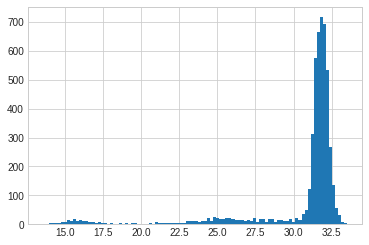

In [1401]:
plt.hist(np.log10(L),100);

In [1402]:
def f(r):
    return abs(r)**-2.4

# n_sim = len(aic_indices)
n_sim = max(n_) 

n = int(1e4)
# r = np.append(np.linspace(-2000,-0.1,n), np.linspace(0.1,2000,n))
r = np.linspace(-2000,2000, n)
pdf = f(r)
pdf = pdf/np.sum(pdf)
r = np.random.choice(r, n_sim, replace = False,p = pdf)

phi = np.linspace(0, np.pi, n_sim)
theta = np.linspace(0, 2 * np.pi, n_sim)
costheta = np.linspace(-1,1, n_sim)
x = []
y = []
z = []
for r_i in r:
    phi_i = random.choice(phi)
    costheta_i = random.choice(costheta)
    theta_i = np.arccos(costheta_i)
#     u = random.choice(np.linspace(0,1, n))
#     r_i = r_i * u**(1.0/3) 
    x = np.append( x, r_i * np.sin(theta_i) * np.cos(phi_i) )
    y = np.append( y, r_i * np.sin(theta_i) * np.sin(phi_i) )
    z = np.append( z, r_i * np.cos(theta_i) )
d = np.sqrt(x**2 + y**2 + z**2)
xyz = np.vstack([x,y,z])
kde = stats.gaussian_kde(xyz)
density = kde(xyz)

In [1403]:
max(x), max(y), max(z), max(d), len(d)

(1920.2636376287473, 1852.2058666190933, 1858.5340103570402, 2000.0, 5047)

In [1404]:
d_MWB = np.sqrt((x-0)**2 + (y-0)**2 + (z-8e3)**2)
d_MWB = d_MWB * 3.086e+18            ## pc to cm
F_cut = 9.61308e-13
F = np.array(L) / (4*np.pi*np.random.choice(d_MWB, len(L))**2)
sum(F>F_cut)*k_bulge

0.0

In [1405]:
F_sam = []
for i in range(200):
    F = np.array(L) / (4*np.pi*np.random.choice(d_MWB, len(L))**2)
    F_sam.append(sum(F>F_cut)*k_bulge)

In [1406]:
np.mean(F_sam)

0.0

In [1408]:
d_MWB = np.sqrt((x-0)**2 + (y-0)**2 + (z-8e3)**2)
d_MWB = d_MWB * 3.086e+18            ## pc to cm
F_cut = 9.61308e-13

t = np.arange(0, t_end, 1e8)
detec = []
# y = []
all = []
for time in range(160):
    L = np.array(dNdL_gamma1[time])
    F = np.array(L) / (4*np.pi*np.random.choice(d_MWB, len(L))**2)
    detec.append( sum(F>F_cut)*k_bulge )
#     y.append( int(sum(i > 32 for i in L)*k_bulge) )
    all.append( sum(L>0.1)*k_bulge  )
    

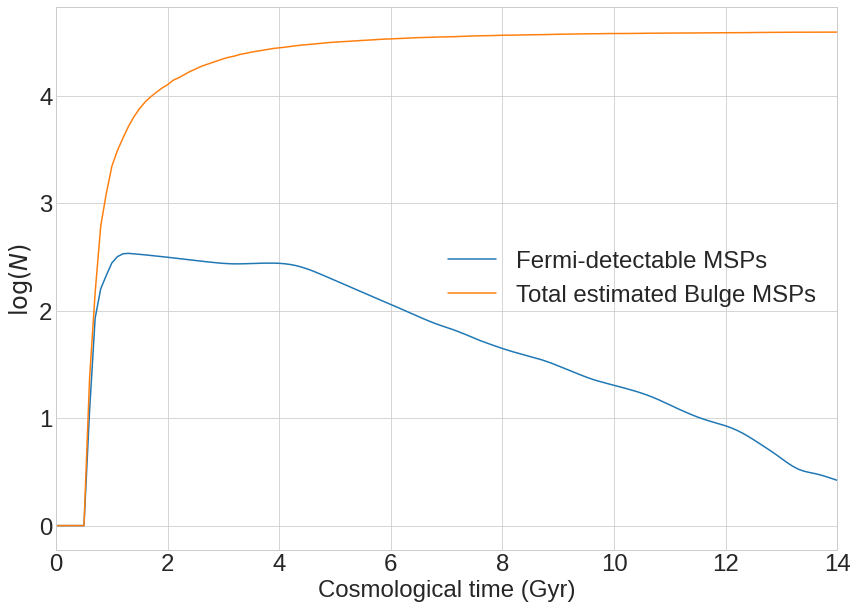

In [1503]:
dt = 1e8
t = np.arange(0, 16e9, dt)
xdata = (t/1e9)
ydata = detec
# y_fit = detec
yfit1 = pd.Series(ydata).rolling(window=60, min_periods=0, center=True).mean()
y_fit = np.append(all[:8], yfit1[8:])
y_fit = pd.Series(y_fit).rolling(window=4, min_periods=0, center=True).mean()
y_fit = np.append(all[:8], y_fit[8:])
y_fit = pd.Series(y_fit).rolling(window=4, min_periods=0, center=True).mean()
y_fit = np.append(all[:8], y_fit[8:])
y_fit = pd.Series(y_fit).rolling(window=2, min_periods=0, center=True).mean()


plt.figure(figsize=(14,10))
plt.plot(t/1e9, np.log10(y_fit, where=y_fit>0), label=r'Fermi-detectable MSPs')
# plt.plot(t/1e9, np.log10(y), label=r'Number of MSPs with $L_\gamma > 10^{32}\ erg\ s^{-1}$ ')
plt.plot(t/1e9, np.log10(all, where=np.array(all)>0), label = "Total estimated Bulge MSPs")
plt.ylabel('$\log(N)$',fontsize=24)
plt.xlabel('Cosmological time (Gyr)',fontsize=24)
# plt.title(r'Number of MSPs',fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
plt.xlim(0,14)
plt.savefig("Nmsps.pdf")
plt.show()

##### min(F_sam), max(F_sam)

/home/gautam/miniconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




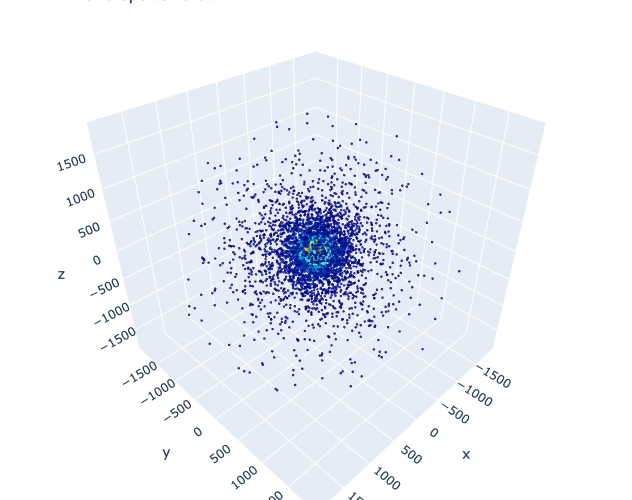

In [1215]:
# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode(connected=True)

data= go.Data([
    go.Scatter3d(
        mode='markers',
#         marker={'size': 0.8, 'opacity': 0.8},
        marker=dict(
        size=1.5,
        color=density,                # set color to an array/list of desired values
        colorscale='jet',   # choose a colorscale
        opacity=0.8
        ),
        x=x,
        y=y,
       
        z=z,
    ),
])


layout = go.Layout(
    title='MW MSPs spatial dist',
    autosize=False,
    width=500,
    height=500,
    margin=go.layout.Margin(l=0, r=0, b=0, t=0)
)


plot_figure = go.Figure(data=data, layout=layout)

# Render the plot. 
plotly.offline.iplot(plot_figure)

In [31]:
# d_MWB = np.sqrt((x-0)**2 + (y-0)**2 + (z-8e3)**2)
# d_MWB = d_MWB * 3.086e+18            ## pc to cm
# F = np.array(np.random.choice(L, len(d_MWB))) / (4*np.pi*d_MWB**2)

# plt.figure(figsize=(10,6))
# plt.hist(np.log10(F), 100, label = "# of LMXBs : %i" %len(F))
# plt.xlabel(r"$\log(FLux (erg/cm^2/s) )$")
# plt.ylabel(r"$N $")
# plt.title("Simulated NS LMXB flux from the inner galaxy")
# # plt.legend()
# plt.savefig("LMXB flux")
# plt.show()

In [238]:
data = pd.read_csv("atnf_bin_msps.txt", sep=";")

In [ ]:
F_atnf = data['EDOT'].astype(float) / 3.086e+21**2
plt.hist(np.log10(F_atnf),20)
plt.xlabel(r"$\log(FLux (erg/cm^2/s) )$")
plt.ylabel(r"$N $")
plt.show()

In [28]:
data = pd.read_csv("fermi_2pc.txt",sep='|')

In [29]:
data = data[data.period.astype(float)<500]

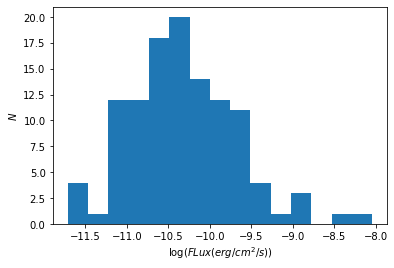

In [30]:
F_fermi2pc = data['flux'].astype(float)
plt.hist(np.log10(F_fermi2pc),15)
plt.xlabel(r"$\log(FLux (erg/cm^2/s) )$")
plt.ylabel(r"$N $")
plt.show()

In [1504]:
data = pd.read_csv("fermi_4fgl.txt",sep='|')

In [1505]:
F_fermi4fgl = data['energy_flux'].astype(float)
# plt.hist(np.log10(F_fermi4fgl),50)
# plt.xlabel(r"$\log(FLux (erg/cm^2/s) )$")
# plt.ylabel(r"$N $")
# plt.show()

In [1506]:
d_MWB = np.sqrt((x-0)**2 + (y-0)**2 + (z-8e3)**2)
d_MWB = d_MWB * 3.086e+18            ## pc to cm

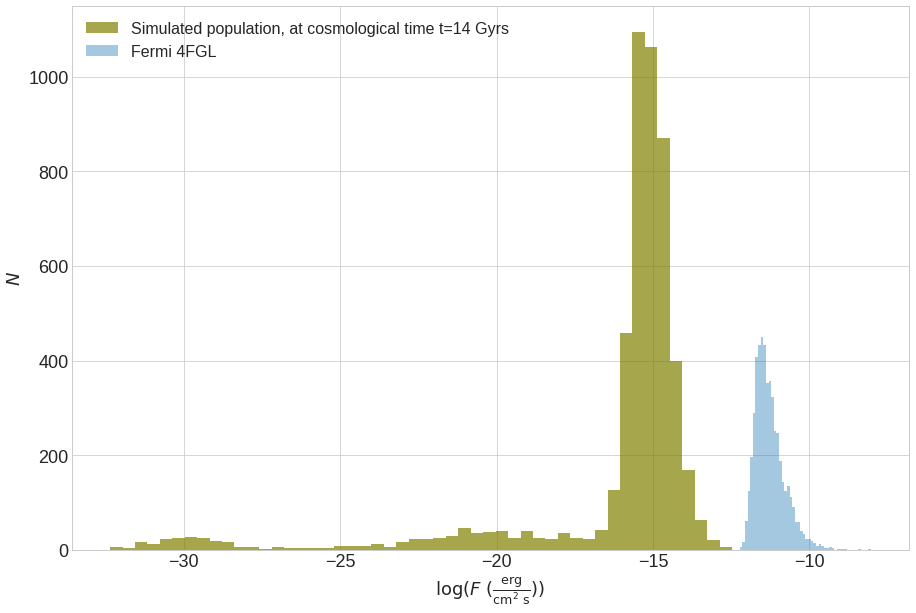

In [1507]:
F = np.array(np.random.choice(L, len(d_MWB))) / (4*np.pi*d_MWB**2)
fig = plt.figure(figsize=(15,10))
# fig.suptitle("Flux distribution", fontsize=18)

# plt.subplot(221)
plt.hist(np.log10(F), color="olive", bins=50, alpha=0.7, label = "Simulated population, at cosmological time t=14 Gyrs")
plt.hist(np.log10(F_fermi4fgl), 50, alpha=0.4, label="Fermi 4FGL")
plt.xlabel(r"$\log(F\ \rm ( \frac{erg}{cm^2 \ s} )  )$", fontsize=18)
plt.ylabel(r"$N $", fontsize=18)
# plt.title("Flux from the simulated pulsars, formed via AIC, at cosmological time t=14 Gyrs", fontsize=16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)

plt.savefig("flux.pdf")
plt.show()

In [700]:
d_MWB = np.sqrt((x-0)**2 + (y-0)**2 + (z-8e3)**2)
d_MWB = d_MWB * 3.086e+18            ## pc to cm
F_cut = 9.61308e-13
F = np.array(np.random.choice(L, len(d_MWB))) / (4*np.pi*d_MWB**2)
sum(F>F_cut)*k_bulge

0.0

In [697]:
F_sam = []
for i in range(500):
    F = np.array(np.random.choice(L, len(d_MWB))) / (4*np.pi*d_MWB**2)
    F_sam.append(sum(F>F_cut)*k_bulge)

In [698]:
np.mean(F_sam)

3.04

In [699]:
min(F_sam), max(F_sam)

(0.0, 30.0)

## Radio

In [1164]:
t_ = 138
d_MWB = np.sqrt((x-0)**2 + (y-0)**2 + (z-8e3)**2)
d_MWB = d_MWB/1e3        ## pc to cm
S_cut = 0.19

p = np.arange(5.4,8,0.1)

Np = []

for pp in p:
    ## at 400 MHz
    L = np.log10(np.array(Pdot1[t_])/np.array(P1[t_])**3.0)/3.0 + pp    ## in mJy
    S_400 = (10**L)/np.random.choice(d_MWB, len(L))**2   ## in mJy

    ## at 1400 MHz
    S_1400=S_400*(400/1400)**1.7

    # If the flux is >0.19 mJy, the MSP could have been detected by the Parkes
    # radio-telescope multi-beam survey.
    N = sum(S_1400>S_cut)*k_bulge
    Np.append(N)

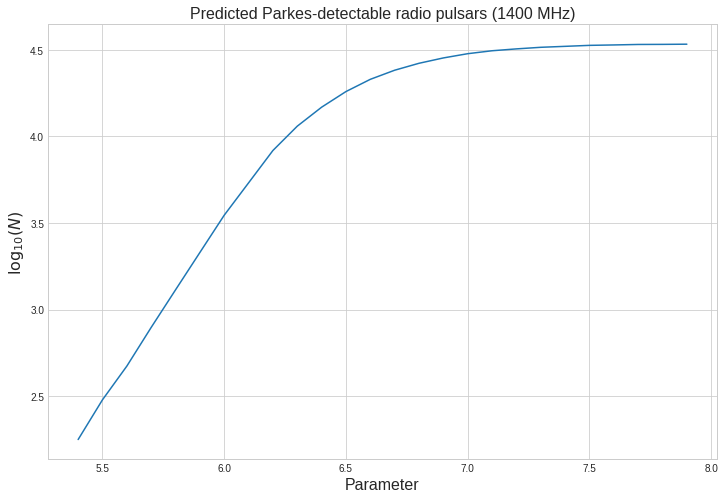

In [1165]:
plt.figure(figsize=(12,8))
plt.plot(p, np.log10(Np))
plt.xlabel("Parameter", fontsize=16)
plt.ylabel(r"$\log_{10}(N)$", fontsize=16)
plt.title("Predicted Parkes-detectable radio pulsars (1400 MHz)", fontsize=16)
plt.show()

In [1366]:
f = []
for i in aic_indices:
    try:
        if ehists_scratch[i][-102,0] == 14000:
            a = []
            a.append(ehists_scratch[i][-102,3])
            a.append(ehists_scratch[i][-102,7])
            a.append(ehists_scratch[i][-102,2])
            a.append(random.choice(d_MWB)/3.086e+21)
            f.append(a)
    except IndexError:
        pass
    

In [1367]:
np.savetxt("GW_data.dat",f, fmt=['%.7f', '%.7f', '%.7f', '%.7f'])

In [1355]:
ehists_scratch[aic_indices[0]][-102,0]

14000.0

In [176]:
6e-9*0.000160218

9.61308e-13